In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import yfinance as yf

# Return Forecasting: Read Historical Daily Yen Futures Data

In this notebook, you will load historical Dollar-Yen exchange rate futures data from the Yahoo Finance API and apply time series analysis and modeling to determine whether there is any predictable behavior.


In [2]:
# Futures contract on the dollar-Yen exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration

df = yf.download('USDJPY=X')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0
...,...,...,...,...,...,...
2022-11-11,141.733994,142.466003,138.888000,141.733994,141.733994,0
2022-11-14,139.552994,140.768997,138.869003,139.552994,139.552994,0
2022-11-15,140.115005,140.580994,137.809006,140.115005,140.115005,0


In [3]:
# Trim the dataset to begin on January 1st, 2000
df = df.loc["2000-01-01":, :]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,102.070000,103.330002,101.309998,101.690002,101.690002,0
2000-01-04,101.639999,103.320000,101.470001,103.139999,103.139999,0
2000-01-05,103.129997,104.480003,102.750000,104.089996,104.089996,0
2000-01-06,104.089996,105.559998,103.900002,105.230003,105.230003,0
2000-01-07,105.260002,105.879997,104.830002,105.330002,105.330002,0


# Return Forecasting: Initial Time-Series Plotting

Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

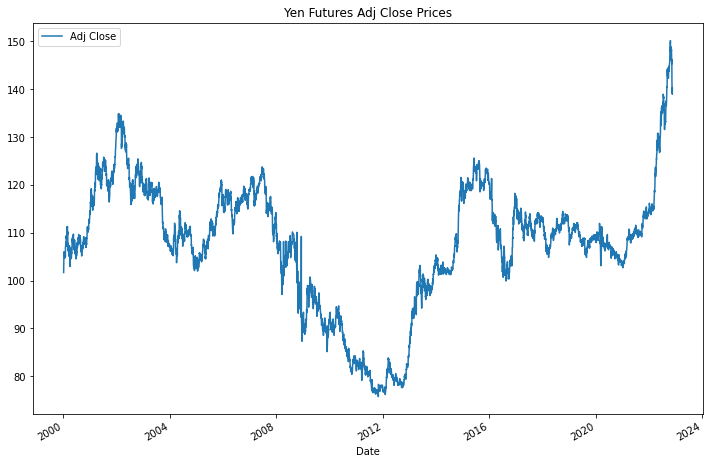

In [4]:
# Plot just the "Adj Close" column from the dataframe:
df_plot=df['Adj Close'].plot(title="Yen Futures Adj Close Prices",figsize=(12,8),legend=True)
df_fig = df_plot.get_figure()
# df_fig.savefig("./Images/Yen_Future_AdjClose_Prices.png")

**Answer:**

*Note, United States dollar is the base currency and the Japanese yen is the counter currency. Therefore when we see price moving upward it means Dollar is gaining strength and Yen is weakening.*

In the long term, It seems that the Japanese Yen is weakening against the Dollar. Historically there has been a lot of short-term ups and downs but this past year we have seen a lot of strength in the dollar.


# Decomposition Using a Hodrick-Prescott Filter

Using a Hodrick-Prescott Filter, decompose the Adj Close price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Adj Close" price into two separate series:
settle_noise, settle_trend = sm.tsa.filters.hpfilter(df['Adj Close'])

In [6]:
# Create a dataframe of just the Adj Close price, and add columns for "noise" and "trend" series from above:
df_yen_futures = df[['Adj Close']].copy()
df_yen_futures['noise'] = settle_noise
df_yen_futures['trend'] = settle_trend
df_yen_futures.head()



,Adj Close,noise,trend
Date,,,
2000-01-03,101.690002,-1.924205,103.614208
2000-01-04,103.139999,-0.672920,103.812919
2000-01-05,104.089996,0.079568,104.010429
2000-01-06,105.230003,1.024891,104.205112
2000-01-07,105.330002,0.934606,104.395396


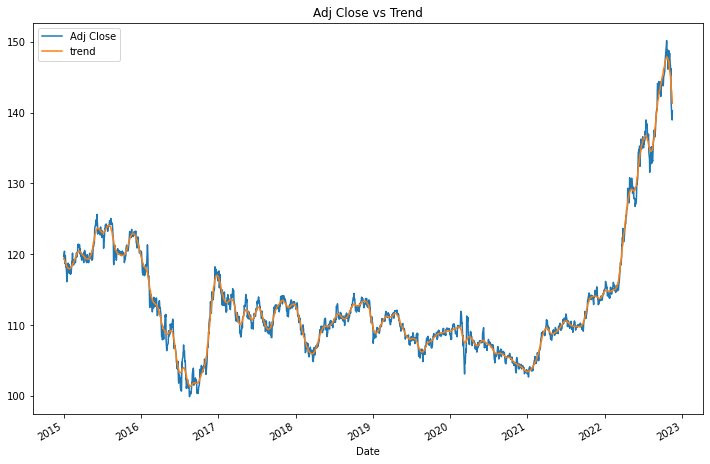

In [8]:
# Plot the Adj Close Price vs. the Trend for 2015 to the present
settle_trend_plot=df_yen_futures['2015':].plot(y=['Adj Close','trend'],title="Adj Close vs Trend",figsize=(12,8),legend=True)
settle_trend_fig = settle_trend_plot.get_figure()
# settle_trend_fig.savefig("./Images/Adj Close vs Trend.png")



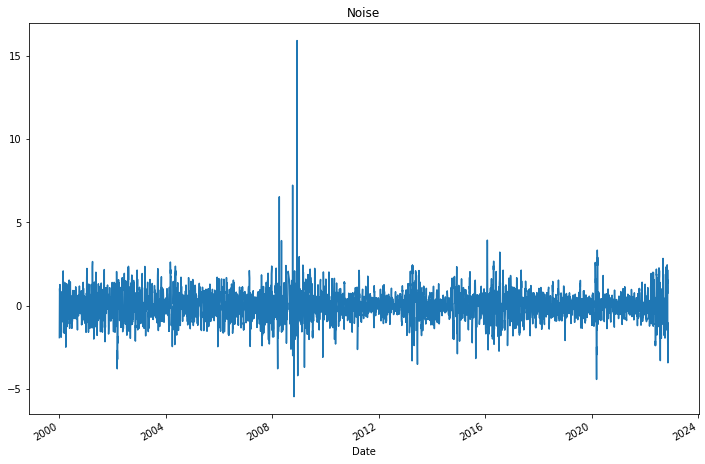

In [9]:
# Plot the Adj Close Noise
noise_plot=df_yen_futures.plot(y=['noise'],title="Noise",figsize=(12,8),legend=False)
noise_fig = noise_plot.get_figure()
# noise_fig.savefig("./Images/Noise.png")

**Answer**

In the the Adj Close Price vs. the Trend plot, It seems that there are a lot of short term fluctuations that deviate around the trend. The Noise plot gave us a visualization of where the most noise is on this chart. These points can be correllated with volatile periods in the market.

# Forecasting Returns using an ARMA Model

Using futures Adj Close Returns, estimate an ARMA model

    - ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2,1). 
    - Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    - Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)



In [10]:
# Create a series using "Adj Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (df[["Adj Close"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Adj Close
Date,
2022-11-11,-3.060691
2022-11-14,-1.538798
2022-11-15,0.402723
2022-11-16,-0.820761
2022-11-17,0.931888


In [11]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
from pmdarima.arima import auto_arima
model = sm.tsa.arima.ARIMA(returns.values, order=(1,1,2))
results = model.fit()


# from statsmodels.tsa.arima.model import ARMA
# model = ARMA(returns.values, order=(2,1))

# # Fit the model and assign it to a variable called results
# results = model.fit()



In [12]:
# Output model summary results:
results.summary()
# print(fitted.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5939
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -6349.514
Date:                Thu, 17 Nov 2022   AIC                          12707.028
Time:                        18:05:49   BIC                          12733.784
Sample:                             0   HQIC                         12716.324
                               - 5939                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0073      0.046      0.161      0.872      -0.082       0.097
ma.L1         -1.1882      0.046    -26.060      0.000      -1.278      -1.099
ma.L2          0.1884      0.046      4.125      0.000       0.099       0.278
sigma2         0.4963      0.002    272.639      0.000       0.493       0.500
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2100079.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             1.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        95.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

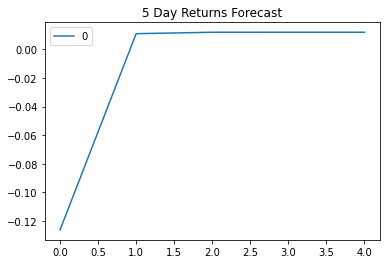

In [13]:
# Plot the 5 Day Returns Forecast

# one-step out-of sample forecast
# forecast = results.forecast(step=5)[0].plot(title="5 Day Returns Forecast")

arma_plot = pd.DataFrame(results.forecast(steps=5)).plot(title="5 Day Returns Forecast")
arma_fig = arma_plot.get_figure()
# arma_fig.savefig("./Images/Arma_Five_Days_Returns.png")



**Answer**

In the summary table, the p-values for each lag are not statistically significant. The model is not a good fit given the p-value exceeds 0.05.


# Forecasting the Adj Close Price using an ARIMA Model

    Using the raw Yen Adj Close Price, estimate an ARIMA model.
        Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
        P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
    Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    Construct a 5 day forecast for the Adj Close Price. What does the model forecast will happen to the Japanese Yen in the near term?



In [14]:
# from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima


# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = sm.tsa.arima.ARIMA(df['Adj Close'], order=(5,1,1))
# Fit the model
results_arima = model.fit()

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Output model summary results:
results_arima.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5940
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -6698.972
Date:                Thu, 17 Nov 2022   AIC                          13411.943
Time:                        18:05:50   BIC                          13458.769
Sample:                             0   HQIC                         13428.213
                               - 5940                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0842      0.499     -0.169      0.866      -1.063       0.895
ar.L2         -0.0137      0.084     -0.162      0.871      -0.179       0.152
ar.L3          0.0174      0.016      1.064      0.287      -0.015       0.049
ar.L4          0.0158      0.013      1.188      0.235      -0.010       0.042
ar.L5         -0.0199      0.014     -1.397      0.163      -0.048       0.008
ma.L1         -0.0858      0.501     -0.171      0.864      -1.067       0.896
sigma2         0.5588      0.002    229.541      0.000       0.554       0.564
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1192779.61
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        72.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


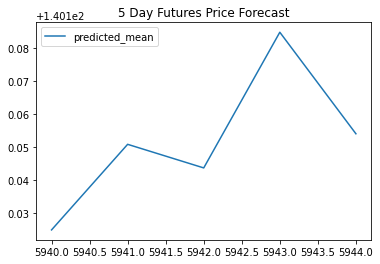

In [16]:
# Plot the 5 Day Price Forecast
arima_plot=pd.DataFrame(results_arima.forecast(steps=5)).plot(title="5 Day Futures Price Forecast")
arima_fig = arima_plot.get_figure()
# arima_fig.savefig("./Images/Arima_Five_Days_Returns.png")



**Answer**

Again, based on the summary table, the p-values for each lag did not show to be statistically significant - none are less than 0.05. Based on the ARIMA model, we can see that an increase in the Yen over the dollar is expected for the 5 day period.


# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term volatility of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.

Using futures Settle Returns, estimate an GARCH model

    GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
    Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
    Plot the 5-day forecast of the volatility.



In [17]:
import arch 

In [18]:
# Estimate a GARCH model:
from arch import arch_model
model_garch = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_garch = model_garch.fit(disp="off")



In [19]:
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5250.77
Distribution:                  Normal   AIC:                           10509.5
Method:            Maximum Likelihood   BIC:                           10536.3
                                        No. Observations:                 5939
Date:                Thu, Nov 17 2022   Df Residuals:                     5939
Time:                        18:05:52   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.7640e-03  1.836e-03      1.505      0.132 [-8.344e-04,6.362e-03]
alpha[1]       0.0565  1.471e-02      3.845  1.205e-04  [2.772e-02,8.537e-02]
alpha[2]       0.0000  1.861e-02      0.000      1.000 [-3.647e-02,3.647e-02]
beta[1]        0.9398  1.692e-02     55.555      0.000      [  0.907,  0.973]
=============================================================================

Covariance estimator: robust
"""

In [20]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day



'2022-11-17'

In [21]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start=last_day, horizon=forecast_horizon, reindex=True)

In [22]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2022-11-17,15.765507,15.758417,15.75135,15.744306,15.737285


In [23]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()



Date,2022-11-17
h.1,15.765507
h.2,15.758417
h.3,15.751350
h.4,15.744306
h.5,15.737285


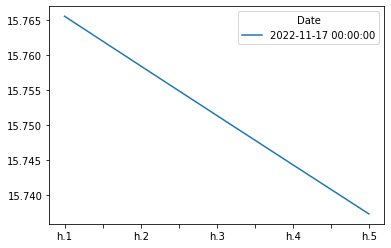

In [24]:
# Plot the final forecast
garch_plot=final.plot()
garch_fig = garch_plot.get_figure()
# garch_fig.savefig("./Images/Garch_forecast.png")



**Answer**

Based on the GARCH forecast plot , volatility risk of the Yen will increase each day for the next 5 days.

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

**Answer**

According to ARMA and ARIMA models, the Japanese Yen will increase relative to the US dollar, however, there might be an unreliable coefficient that might cause misleading result because the p-values are greater than 0.05. Thus, I would not buy the Japanese Yen.

Based on the GARCH forcast, volatility risk of the Yen will increase each day.

Again, due to p- values are not less than 0.05, I do not feel confident in using these models for trading.